In [1]:
#導入相關模組
import json
import random
import re

import jieba
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

#讀取jieba所需的自建辭典
jieba.load_userdict("E:/Python 3.7/pyetl/Demodb0103/gym/data/dict.txt")
import time

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\BIGDAT~1\AppData\Local\Temp\jieba.cache
Loading model cost 3.029 seconds.
Prefix dict has been built succesfully.


In [2]:
#讀取要斷詞的json檔
DATASET_DIR = 'E:/Python 3.7/pyetl/Demodb0103/gym/data/gymz.json'
with open(DATASET_DIR, encoding='utf8') as f:
    dataset = json.load(f)

In [4]:
#讀取停止詞典
STOP_WORDS_DIR = 'E:/Python 3.7/pyetl/Demodb0103/gym/data/stopWords.txt'
with open(STOP_WORDS_DIR, encoding='utf8') as f:
    stop_words = f.read().splitlines() 

In [5]:
#抽出文章的標題與內容
content_list = list(map(lambda d: d['content'], dataset))
title_list = list(map(lambda d: d['title'], dataset))

In [6]:
#替換不需要的句子
# start = time.clock()
gym_list =[]
for i in content_list:
    i = re.sub('※ 發信站: 批踢踢實業坊',' ', i)
    i = re.sub('※ 文章網址:',' ', i)
    i = re.sub('※ 編輯:',' ', i)
    i = re.sub('(臺灣)',' ', i)
    i = re.sub('來自:',' ', i)
    gym_list.append(i)

In [7]:
#將文章正規化，並進行jieba斷詞
rule = re.compile(r"[^\u4e00-\u9fa5]")
gym_list = [list(jieba.cut(rule.sub('', speech))) for speech in gym_list]

In [8]:
#去除停止詞
for idx, speech in enumerate(gym_list):
    gym_list[idx] = ' '.join([word for word in speech if word not in stop_words])
# end = time.clock()
# print('運行時間: ' + str(end - start))

In [9]:
# 使用 tf-idf 向量化
#TfidfTransformer + CountVectorizer = TfidfVectorizer
# 需要設置（sublinear_tf = True，use_idf = True）使特徵值近似於高斯分佈
# ，這能彌補LSA對於文本數據的錯誤的替代假設
tfidf_vectorizer = TfidfVectorizer(max_features = None,
                                   sublinear_tf=True, 
                                   use_idf=True,
                                   max_df=0.9,
                                   min_df=25,
                                   ngram_range=(1, 4))
                                   
#將算出的tf-idf 先擬合數據，然後轉化為其其轉化為標準形式
tfidf = tfidf_vectorizer.fit_transform(gym_list)
# 將tf-idf矩陣抽取出來，元素w [i] [j]表示j詞在i類文本中的tf-idf權重
tfidf1 = tfidf.toarray()

In [10]:
#使用LSA語意分析降維
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pandas as pd
#使用TruncatedSVD,把原先規模為(文字數，詞彙數)的特徵矩陣X化為規模為(文字數，主題數)的新特徵矩陣X2：
#(由於主題數一般比詞彙數少，這一方法也可以用來降維，以進行分類或聚類操作)
lsa_model = TruncatedSVD(n_components=100, algorithm='arpack')
lsa_vecs = lsa_model.fit_transform(tfidf)
#使用Normalization(正則化)，形成獨立同分佈與白化
lsa_vecs = Normalizer(copy=False).fit_transform(lsa_vecs)

#顯示關鍵字lsa表格
feature_names = tfidf_vectorizer.get_feature_names()
lsa_df = pd.DataFrame(lsa_model.components_.round(5), columns=feature_names)

KMeans分群

In [11]:
# import numpy as np
# np.random.seed(123)
#跑KMeans分群用簇內誤方差（SSE）決定最佳分群數k
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, init='k-means++',n_jobs=-1)
    kmeans.fit(lsa_vecs)
    wcss.append(kmeans.inertia_)
    print('k={}, inertia={}'.format(k, kmeans.inertia_))

k=2, inertia=17091.812212301353
k=3, inertia=16698.120166778084
k=4, inertia=16353.932446188028
k=5, inertia=16104.604160261062
k=6, inertia=15905.17438346898
k=7, inertia=15703.365012608327
k=8, inertia=15525.473058504103
k=9, inertia=15363.180745947071
k=10, inertia=15195.213989761456
k=11, inertia=15020.135133790302
k=12, inertia=14905.863338932462
k=13, inertia=14760.531111309418
k=14, inertia=14620.323045021536
k=15, inertia=14529.156619863154
k=16, inertia=14378.503618909526
k=17, inertia=14236.549345582958
k=18, inertia=14151.340213198748
k=19, inertia=14070.87260402676


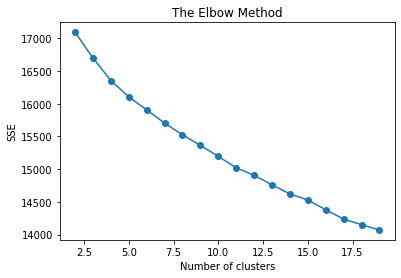

In [12]:
#畫圖
plt.plot(range(2, 20), wcss,marker="o")
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [13]:
#K-Means, k=11
kmeans = KMeans(n_clusters=11, init='k-means++',n_jobs=-1)
kmeans.fit(lsa_vecs)
clusters = kmeans.predict(lsa_vecs)

In [14]:
#基於通過LSA創建的2個潛在維度的10個群集。
kmeans.cluster_centers_.shape

(11, 100)

In [15]:
#探索原始尺寸
original_space_centroids = lsa_model.inverse_transform(kmeans.cluster_centers_)
original_space_centroids.shape

(11, 6950)

In [16]:
order_centroids = original_space_centroids.argsort()[:, ::-1]
order_centroids.shape

(11, 6950)

In [18]:
#檢查每個群集中的前10個TF-IDF功能
for cluster in range(11):
    features = order_centroids[cluster,0:5]
    print('Cluster {}\n'.format(cluster))
    for feature in features:
        print(feature_names[feature])
    print('\n')

Cluster 0

面交
內信
空桶
全新
自取


Cluster 1

訓練
動作
重量
肌肉
影片


Cluster 2

胸痛
心臟
情況
疾病
活動


Cluster 3

運動
重訓
體重
飲食
有氧


Cluster 4

教練
推薦
健身房
健身
課程


Cluster 5

動作
感覺
重量
硬舉
姿勢


Cluster 6

健身房
器材
運動
推薦
最近


Cluster 7

健身
最近
小弟
請問
真的


Cluster 8

蛋白
熱量
攝取
脂肪
碳水


Cluster 9

乳清
口味
巧克力
蛋白
味道


Cluster 10

有人
請問
謝謝
最近
推薦




In [ ]:
#跑KMeans分群用labels決定最佳分群數k
# from sklearn.metrics import silhouette_score
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
# %matplotlib inline


# scores = [] 
# ks = []

# for k in range(2, 20): 
#     clu = KMeans(n_clusters = k,init='k-means++',n_jobs=-1) 
#     clu.fit(lsa_vecs) 
#     clu_score = silhouette_score(lsa_vecs, clu.labels_) 
#     scores.append(clu_score) 
#     ks.append(k)
# print("分數:", scores) 
# print("K 值:", ks) 
# plt.plot(scores, ks)

MiniBatchKMeans分群

In [ ]:
# # import numpy as np
# # np.random.seed(123)
# #跑MiniBatchKMeans分群用簇內誤方差（SSE）決定最佳分群數k
# from sklearn.cluster import MiniBatchKMeans
# wcss = []
# for k in range(2, 20):
#     kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++')
#     kmeans.fit(lsa_vecs)
#     wcss.append(kmeans.inertia_)
#     print('k={}, inertia={}'.format(k, kmeans.inertia_))
# plt.plot(range(2, 20), wcss,marker="o")
# plt.title('The Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('SSE')
# plt.show()

In [ ]:
# #畫圖
# plt.plot(range(2, 20), wcss,marker="o")
# plt.title('The Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('SSE')
# plt.show()